##### Cargue de librerias

In [31]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import warnings
warnings.filterwarnings("ignore")

##### Conexion al ERP/DWH de Dispapeles y cargue de bds adicionales

In [ ]:
## Conexion al AS
""" cnxn = pyodbc.connect(
    driver='{iSeries Access ODBC Driver}',
    system='192.168.100.2',
    uid='TBLPRDUSR',
    pwd='bbbb')
cursor = cnxn.cursor() """
#cnxn.close()

#Cargue de la data desde el ERP de Dispapeles y se guarda en df
# cursor.execute('SELECT DSTCOD AS "Codigo distrito", VTAZNA AS "Codigo zona", VTANIT AS "Nit cliente", ((2022 - LEFT(MAX(VTAFCH),4)) * 12 ) + (6 - SUBSTRING(MAX(VTAFCH),5,2)) AS "Recency", SUM(A.VTAVLRVTA) AS "Monetary", COUNT( DISTINCT LEFT(VTAFCH, 6)) AS "Frequency" FROM SIDPRDDTA.VTAHEC A WHERE PRMCOD = 1 AND A.DSTCOD = 10 AND A.VTAZNA < 96 AND LEFT(VTAFCH,6) BETWEEN 202011 AND 202210 GROUP BY DSTCOD, VTAZNA, VTANIT')
# rows = cursor.fetchall()
# df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [2]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [3]:
codigo_SQL = "SELECT A.DSTCOD AS 'Codigo distrito', B.VNDZNA AS 'Codigo zona actual', CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC) AS 'Nit cliente-sucursal', A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', (((2021 - MAX(A.VTAANO)) * 12 ) + (0 - MAX(A.VTAMES))) * -1 AS 'Recency', SUM(A.VTAVLRVTA) AS 'Monetary', COUNT( DISTINCT A.VTAMES) AS 'Frequency' FROM V_VTA_VTAHEC A LEFT JOIN	DIM_CLIENTES B ON A.PRMCOD = B.PRMCOD AND A.DSTCOD = B.DSTCOD AND A.VTANIT = B.CLTNIT AND A.VTASUC = B.CLTSUC WHERE A.PRMCOD = 1 AND A.DSTCOD NOT IN (30,35) AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN '2021-01-01' AND '2022-12-31' GROUP BY A.DSTCOD, B.VNDZNA, CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC),	A.VTAANO, A.VTAMES HAVING SUM(A.VTAVLRVTA) > 0"

In [4]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [5]:
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")

##### Tranformaciones

In [6]:
df["Monetary"] = df["Monetary"].astype(int)

In [7]:
df_2 = pd.merge(df, maestra_zonas, on= ["Codigo distrito", "Codigo zona actual"])

In [8]:
list_filter = ['Artes graficas', 'V Horeca', 'Institucional', 'V SyE',
                'V Industria', 'Mayorista']

In [9]:
df = df_2[df_2["Nombre tipo zona"].isin(list_filter)]

In [10]:
df.describe()

,Codigo distrito,Codigo zona actual,Ano,Mes,Recency,Monetary,Frequency
count,123427.000000,123427.000000,123427.000000,123427.000000,123427.000000,1.234270e+05,123427.0
mean,40.382518,39.111248,2021.519692,6.574971,12.811273,7.214459e+06,1.0
std,23.561828,29.349243,0.499614,3.434467,6.921857,2.594011e+07,0.0
min,10.000000,1.000000,2021.000000,1.000000,1.000000,0.000000e+00,1.0
25%,20.000000,8.000000,2021.000000,4.000000,7.000000,3.048230e+05,1.0
50%,40.000000,60.000000,2022.000000,7.000000,13.000000,1.090560e+06,1.0
75%,60.000000,65.000000,2022.000000,10.000000,19.000000,4.400280e+06,1.0
max,90.000000,96.000000,2022.000000,12.000000,24.000000,1.355925e+09,1.0


In [12]:
df_3 = df.groupby(["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal"]).agg({"Recency": np.max,
                                                                            "Monetary": np.sum,
                                                                            "Frequency": np.sum
                                                                            })
df_3 = df_3.reset_index(col_level= 1)
df_3

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency
0,10,Artes graficas,1010197660-1,14,2856739,1
1,10,Artes graficas,1010208977-1,1,1732800,1
2,10,Artes graficas,1012348815-1,2,78219,1
3,10,Artes graficas,1013637504-1,4,150045,1
4,10,Artes graficas,1013642113-1,24,5571618,1
...,...,...,...,...,...,...
14307,90,Mayorista,93300278-1,17,1990949,5
14308,90,Mayorista,93370623-1,24,19617604,23
14309,90,Mayorista,93386132-1,22,721928263,19
14310,90,Mayorista,93414007-1,24,18084903,15


In [13]:
#Se añade una key de Distrito-Nombretipozona para hacer mas facil la identificacion cuando se usa todo el pais
#Se genera la calificacion de Recency basado en los valores máximos
#Se divide por millón la columna Monetary para disminuir el rango de los valores
df_3['Distrito-Nombretipozona'] = df_3['Codigo distrito'].astype(str) + '-' + df_3['Nombre tipo zona']
df_3['Monetary'] = (df_3['Monetary'] / 1000).astype(int)
df_3['Frequency'] = (df_3['Frequency']).astype(int)

In [14]:
df_3.describe()

,Codigo distrito,Recency,Monetary,Frequency
count,14312.000000,14312.000000,1.431200e+04,14312.000000
mean,41.646381,18.902390,6.221718e+04,8.624022
std,23.955554,6.644126,2.959577e+05,7.910759
min,10.000000,1.000000,4.000000e+00,1.000000
25%,20.000000,15.000000,9.640000e+02,2.000000
50%,40.000000,22.000000,4.668000e+03,5.000000
75%,60.000000,24.000000,2.357875e+04,14.000000
max,90.000000,24.000000,1.513502e+07,24.000000


##### Creacion, ajuste y descarga de los modelos de clustering por cada distrito-tipo de zona

In [15]:
list_dtos = df_3["Distrito-Nombretipozona"].unique()

In [ ]:
list_dtos = ['10-Artes graficas', '10-Institucional']

In [141]:
numeric_features = ["Recency", "Monetary", "Frequency"]
ignore_columns = ["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal", "Distrito-Nombretipozona"]
normalizar = [False, True]

In [228]:
bd_predicted = pd.DataFrame([])
metrics = []
fecha = '1-2-23'

for norm in normalizar:
    for n, dto in enumerate(list_dtos):
        print(f"Procesando modelo normalizado {norm} {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
        
        #BD filtrada
        df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
        
        #Setup del modelo 
        s = setup(
                    df_dto,
                    normalize = norm,
                    verbose= False,
                    preprocess= False,
                    silent= True,
                    profile= False,
                    ignore_features= ignore_columns,
                    numeric_features= numeric_features
                    )
        
        #Creacion y prediccion de modelo
        model_kmeans = create_model(
                                    'kmeans',
                                    num_clusters= 5,
                                    verbose= False,
                                    )
        pull()
        df_pred_km = predict_model(
                                    model_kmeans,
                                    data = df_dto
                                    )
        
        # Reasignacion de los nombres de los clusters
        trans = df_pred_km.groupby(
                                    ["Cluster"]).agg({
                                                    "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                    }).sort_values(
                                                                    by= ["Recency", "Frequency", "Monetary"],
                                                                    ascending= False
                                                                    ).reset_index()
        trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
        trans = trans[["Cluster", "Letra cluster"]]
        
        df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
        
        # Descargue del modelo
        bd_predicted = bd_predicted.append(df_pred_km)

        #Append a una base general
        metrics.append({
                        "Distrito-zona": dto,
                        "Normalizado": norm,
                        "Silhouette": pull().Silhouette[0],
                        "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                        "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                        })
        # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

metrics = pd.DataFrame(metrics)
metrics["Normalizado"] = metrics["Normalizado"].replace([True, False], ["Si","No"])
metrics["Tipo zona"] = metrics["Distrito-zona"].str[3:]

print("Proceso completo 100%")

Procesando modelo normalizado False 1 de 65. 1.5%
Procesando modelo normalizado False 2 de 65. 3.1%
Procesando modelo normalizado False 3 de 65. 4.6%
Procesando modelo normalizado False 4 de 65. 6.2%
Procesando modelo normalizado False 5 de 65. 7.7%
Procesando modelo normalizado False 6 de 65. 9.2%
Procesando modelo normalizado False 7 de 65. 10.8%
Procesando modelo normalizado False 8 de 65. 12.3%
Procesando modelo normalizado False 9 de 65. 13.8%
Procesando modelo normalizado False 10 de 65. 15.4%
Procesando modelo normalizado False 11 de 65. 16.9%
Procesando modelo normalizado False 12 de 65. 18.5%
Procesando modelo normalizado False 13 de 65. 20.0%
Procesando modelo normalizado False 14 de 65. 21.5%
Procesando modelo normalizado False 15 de 65. 23.1%
Procesando modelo normalizado False 16 de 65. 24.6%
Procesando modelo normalizado False 17 de 65. 26.2%
Procesando modelo normalizado False 18 de 65. 27.7%
Procesando modelo normalizado False 19 de 65. 29.2%
Procesando modelo normaliza

In [227]:
metrics

,Distrito-zona,Normalizado,Silhouette,Calinski-Harabasz,Davies-Bouldin,Tipo zona
0,10-Artes graficas,No,0.7661,2134.2232,0.5120,Artes graficas
1,10-Institucional,No,0.9437,14501.7164,0.1813,Institucional
2,10-Mayorista,No,0.7980,2010.1265,0.3790,Mayorista
3,10-V Horeca,No,0.7277,2825.2782,0.1981,V Horeca
4,10-V Industria,No,0.7652,2339.9547,0.3789,V Industria
...,...,...,...,...,...,...
125,75-Institucional,Si,0.8705,2290.0138,0.3489,Institucional
126,75-Mayorista,Si,0.8336,3058.4100,0.3456,Mayorista
127,90-Artes graficas,Si,0.7902,4077.9982,0.4237,Artes graficas
128,90-Institucional,Si,0.8300,4233.8617,0.3623,Institucional


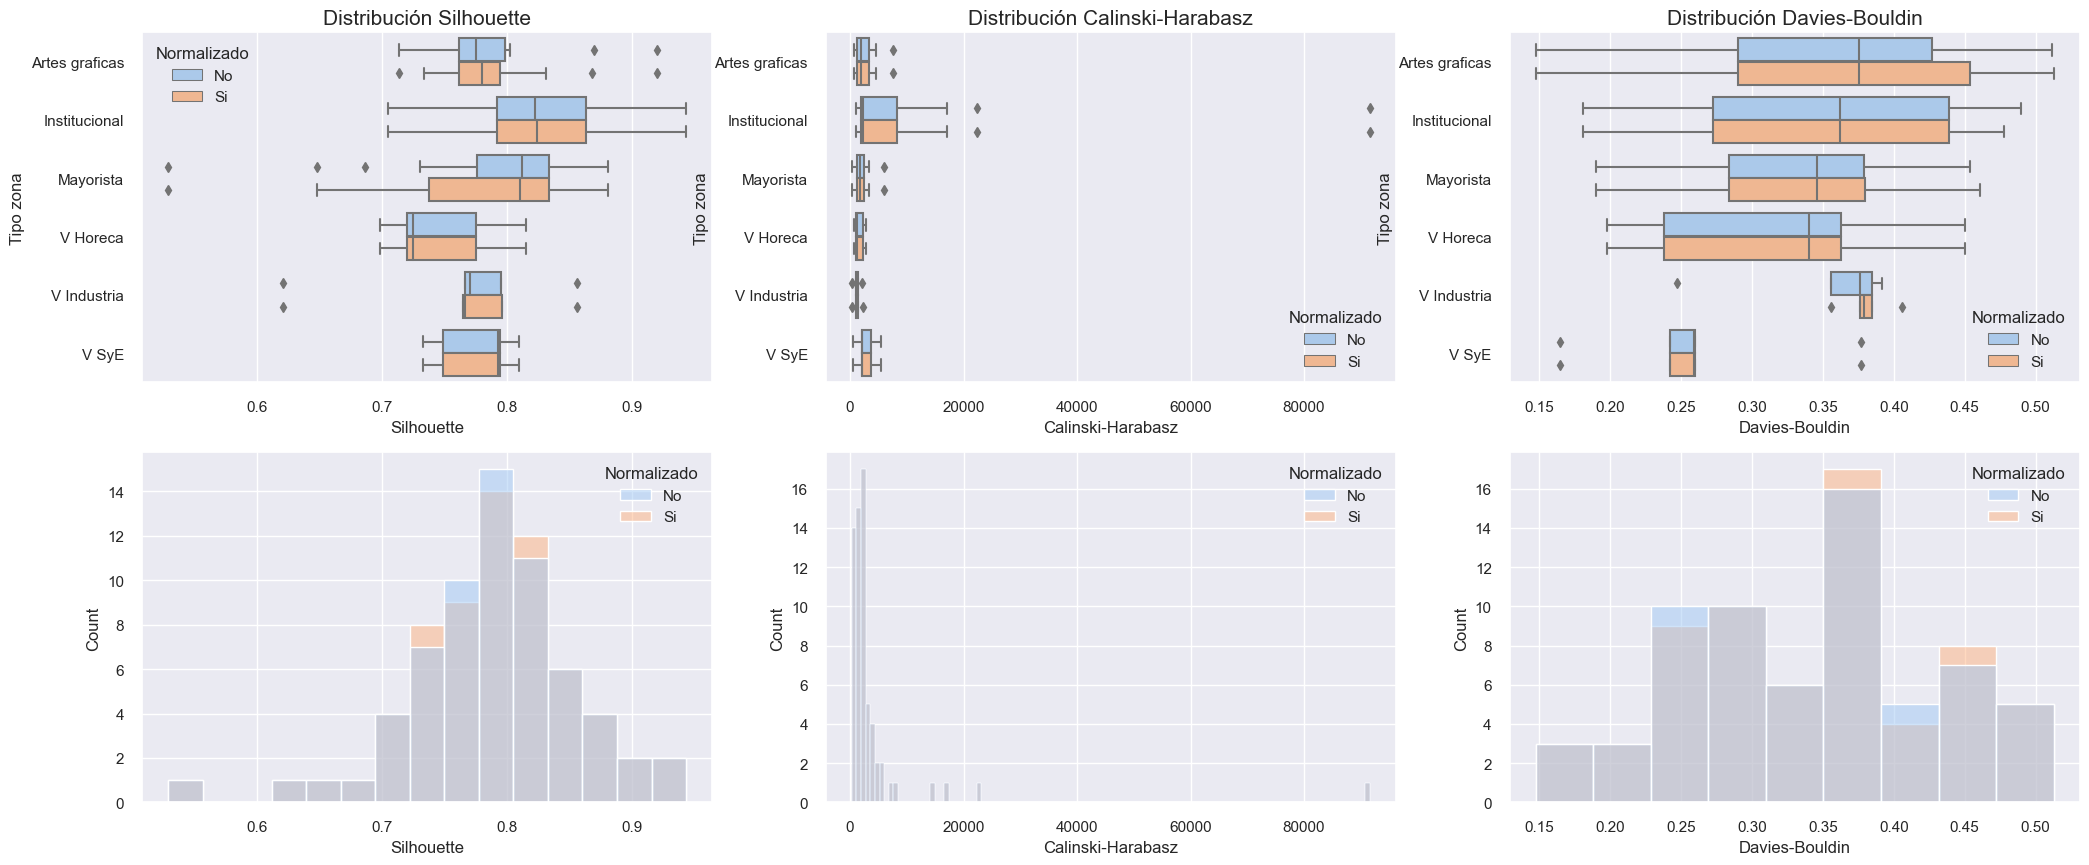

In [231]:
f, axarr = plt.subplots(2,3)
f.set_figheight(10)
f.set_figwidth(25)

metricas = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]

for n, met in enumerate(metricas):
    f.add_subplot(axarr[0,n])
    plt.title(f"Distribución {met}").set_fontsize(15)
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.boxplot(data= metrics, x= met, y= "Tipo zona", hue= 'Normalizado')

    f.add_subplot(axarr[1,n])
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.histplot(data= metrics, x= met, hue= 'Normalizado')
plt.show()



In [236]:
metrics[metrics['Normalizado'] == "Si"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,65.000000,65.000000,65.000000
mean,0.788268,4373.143237,0.343095
std,0.069285,11606.441631,0.091144
min,0.528600,314.872400,0.147600
25%,0.755600,1211.737600,0.272800
50%,0.793000,2012.721800,0.355600
75%,0.829200,3284.437600,0.404900
max,0.943700,91584.139500,0.512700


In [233]:
metrics[metrics['Normalizado'] == "No"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,65.000000,65.000000,65.000000
mean,0.788520,4373.379417,0.339806
std,0.068637,11609.249166,0.090071
min,0.528600,314.872400,0.147600
25%,0.760100,1211.737600,0.269900
50%,0.794800,2012.721800,0.352900
75%,0.824600,3284.437600,0.391400
max,0.943700,91608.675200,0.511800


In [237]:
#Descargue de bd predicha y metricas calculadas
bd_predicted.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",", sep= ";")
metrics.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Metricas {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",",  sep= ";")

Text(0.5, 0, 'Frequency')

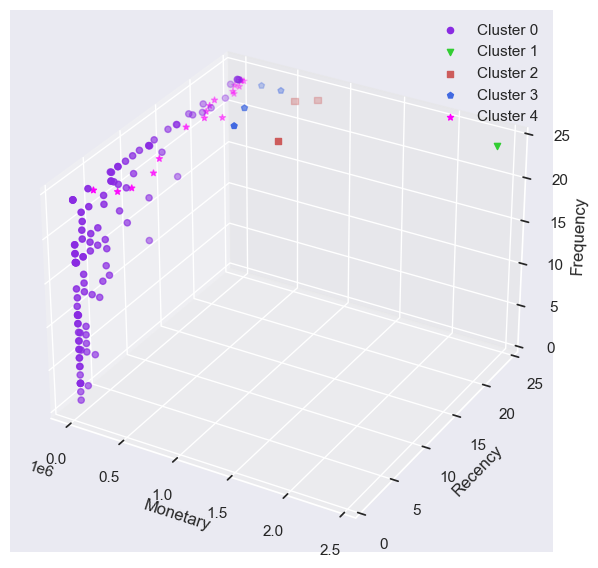

In [238]:
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
cluster = list(np.unique(df_pred_km['Cluster']))

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'],df_plot['Frequency'], df_plot['Recency'] , marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [239]:
plot_model(model_kmeans, plot = 'cluster')

In [ ]:
# saved_model =  load_model('Model Version random 9-11')